In [20]:
''' ======= A brief description: ======= 
Importing related packages
'''
import torch
import torch.nn as nn
import torch.utils.data as data
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

In [21]:
''' ======= A brief description: ======= 
Printing pytorch version and detecting GPU. 
'''
print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # prefer gpu
print("Device", device)

Using torch 2.2.1+cu121
Device cuda


In [22]:
''' ======= A brief description: ======= 
There 

'''
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1, device=device):
        """Make a random XOR data set.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)
        # Move data to GPU if relevant
        self.data = data.to(device)
        self.label = label.to(device)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def toNumpy(self):
        return (self.data.cpu().numpy(), self.label.cpu().numpy()) # must be on cpy to convert to numpy

Size of dataset: 200
Data point 0: (tensor([-0.0625, -0.0241], device='cuda:0'), tensor(0, device='cuda:0'))


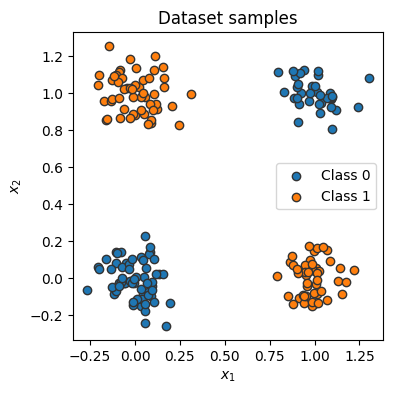

In [23]:
''' ======= A brief description: ======= 
'''
def visualize_binary_samples(dataset):
    """visualize a data set with binary labels.

    Args:
        data: the data set as, e.g., generated by XORDataset
    """
    (data,label) = dataset.toNumpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
visualize_binary_samples(dataset)
plt.show()

In [24]:
''' ======= A brief description: ======= 
'''
class SimpleClassifier(nn.Module):
    def __init__(self, src, tg, depth, width, device=device):
        """Make a convolutional neural network. Last layer uses the identity transfer function, the rest use the tanh.

        Args:
            src: The number of input nodes
            tg: The number of output nodes
            depth: The number of hidden layers
            width: The width of the hidden layers
        """
        super().__init__()

        self.enc_sizes = [src, tg, depth, width]


        ###############################################################################################
        # Assignment: replace self.model with your code for a network src-width-width-...-tg network
        ###############################################################################################
        functionLst = []
        if depth:
            functionLst.append(nn.Linear(src, width)) # first hidden layer
            functionLst.append(nn.Tanh()) # first hidden layer
            for _ in range(depth - 1):
                functionLst.append(nn.Linear(width, width))  # Additional hidden layers
                functionLst.append(nn.Tanh())
            functionLst.append(nn.Linear(width, tg))  # Output layer 
        else: # depth == 0
            functionLst.append(nn.Linear(src, tg))
        functionLst.append(nn.Identity())
        self.model = nn.Sequential(*functionLst) #unpacking with the '*' operator

        # Move data to GPU if relevant
        self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(dim=1) # flat

        return x

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    """Train a model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        data_loader: The function to load the data
        loss_module: The function to evaluate the loss function
        num_epochs: The number of epochs to train
    """
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Step 1: Run the model on the input data
            preds = model(data_inputs)
            #preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 2: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 4: Update the parameters
            optimizer.step()

def eval_model(model, data_loader):
    """Evaluate a model.

    Args:
        model: A (trained) model
        data_loader: The function to load the data
    """
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    return acc

In [25]:
###############################################################################################
# Assignment: replace the following with code that trains your networks repeatedly on the same
# XORDataset for a range of depths and widths, e.g., depths and widths in the range range(4)
# and each repeated 3 times.
###############################################################################################

''' ======= A brief description: ======= 
As a minimum try repeatedly all combinations of 0 ...3 hidden layers with widths 1 ...3.
In total, there are 12 models 
'''
'''
Questions:
1. Will we have to write code to calculate the loss of every test sample? Then calculate the mean and std of each model predictions?
2. What is the loss function? BCEWithLogitsLoss?
3. What do they mean by "each repeated 3 times"?
'''

# Setup a feed-forward network with variable width
loss_matrix = np.zeros((10, 3))
model_parameters = []
for k in range(3): # repeat 3 times
    loss_module = nn.BCEWithLogitsLoss()
    train_dataset = XORDataset(size=1000)
    train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_dataset = XORDataset(size=500)
    # drop_last -> Don't drop the last batch although it is smaller than 128
    test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

    # Use the same XORDataset for a range of depths and widths
    model_idx = 0
    for d in range(4):
        for w in range(1, 4):
            model = SimpleClassifier(src=2, tg=1, depth=d, width=w)
            # print(model)

            # Train
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            train_model(model, optimizer, train_data_loader, loss_module, num_epochs=200)

            # Evaluate
            acc = eval_model(model, test_data_loader)
            # print('acc:', acc)
            loss_matrix[model_idx, k] += acc
            print(model_idx, d, w)
            model_idx += 1
            model_parameters.append(sum(p.numel() for p in model.parameters()))
            if d == 0:
                break


0 0 1
1 1 1
2 1 2
3 1 3
4 2 1
5 2 2
6 2 3
7 3 1
8 3 2
9 3 3
0 0 1
1 1 1
2 1 2
3 1 3
4 2 1
5 2 2
6 2 3
7 3 1
8 3 2
9 3 3
0 0 1
1 1 1
2 1 2
3 1 3
4 2 1
5 2 2
6 2 3
7 3 1
8 3 2
9 3 3


In [26]:
loss_matrix

array([[0.43400002, 0.5       , 0.47200003],
       [0.75400001, 0.73200005, 0.75800002],
       [0.54800004, 0.76400006, 0.69800001],
       [1.        , 1.        , 1.        ],
       [0.77000004, 0.72800004, 0.76200002],
       [0.5       , 0.76400006, 0.72400004],
       [0.75400001, 1.        , 0.76000005],
       [0.50600004, 0.77200001, 0.52200001],
       [1.        , 0.77600002, 0.52200001],
       [0.99800003, 1.        , 1.        ]])

In [33]:
model_parameters = model_parameters[:int(len(model_parameters)/3)]
print(model_parameters)

[3, 5, 9, 13, 7, 15, 25, 9, 21, 37]


In [28]:
means = np.mean(loss_matrix, axis=1)
stds = np.std(loss_matrix, axis=1)
print(means)
print(stds)

[0.46866668 0.74800003 0.67000004 1.         0.75333337 0.6626667
 0.83800002 0.60000002 0.76600001 0.99933334]
[0.02704728 0.01143093 0.09037699 0.         0.01820866 0.11617613
 0.11457747 0.12179764 0.19527075 0.0009428 ]


Text(0, 0.5, 'Accuracy')

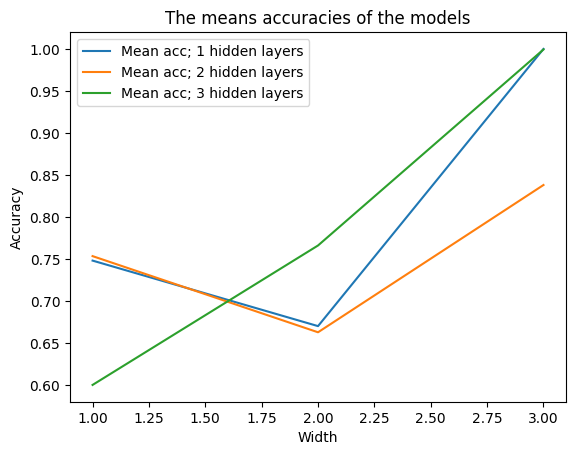

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
for d in range(1, 4):
    line, = plt.plot( range(1, 4), means[(d-1)*3+1:d*3+1])
    line.set_label(f"Mean acc; {d} hidden layers")

plt.legend(loc='upper left'); # 设置标注位置
plt.title('The means accuracies of the models')
plt.xlabel('Width')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Standard deviation')

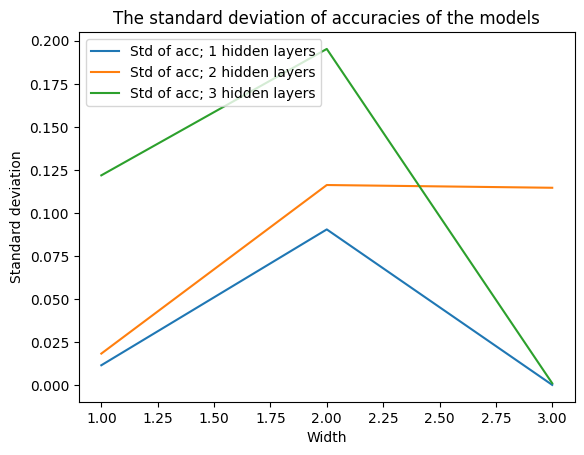

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
for d in range(1, 4):
    line, = plt.plot( range(1, 4), stds[(d-1)*3+1:d*3+1])
    line.set_label(f"Std of acc; {d} hidden layers")

plt.legend(loc='upper left'); # 设置标注位置
plt.title('The standard deviation of accuracies of the models')
plt.xlabel('Width')
plt.ylabel('Standard deviation')


In [37]:
m_means = means.reshape(len(means), 1)
m_stds = stds.reshape(len(stds), 1)
m_model_parameters = np.array(model_parameters).reshape(len(model_parameters), 1)
mean_std_vs_parameters = np.concatenate((m_model_parameters, m_means, m_stds), axis=1)
mean_std_vs_parameters

array([[3.00000000e+00, 4.68666683e-01, 2.70472785e-02],
       [5.00000000e+00, 7.48000026e-01, 1.14309336e-02],
       [9.00000000e+00, 6.70000037e-01, 9.03769929e-02],
       [1.30000000e+01, 1.00000000e+00, 0.00000000e+00],
       [7.00000000e+00, 7.53333370e-01, 1.82086625e-02],
       [1.50000000e+01, 6.62666698e-01, 1.16176135e-01],
       [2.50000000e+01, 8.38000019e-01, 1.14577471e-01],
       [9.00000000e+00, 6.00000024e-01, 1.21797639e-01],
       [2.10000000e+01, 7.66000013e-01, 1.95270746e-01],
       [3.70000000e+01, 9.99333342e-01, 9.42796903e-04]])

Text(0.5, 0, 'Model size')

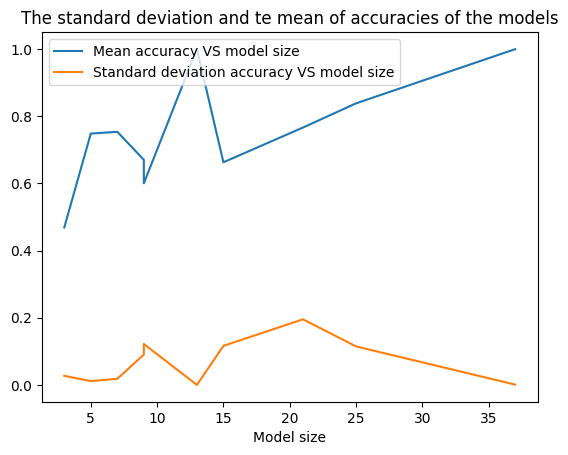

In [39]:
sorted_indices = np.argsort(mean_std_vs_parameters[:, 0])

import numpy as np
import matplotlib.pyplot as plt

# red dashes, blue squares and green triangles
line, = plt.plot(mean_std_vs_parameters[sorted_indices, 0], mean_std_vs_parameters[sorted_indices, 1])
line.set_label("Mean accuracy VS model size")

line, = plt.plot(mean_std_vs_parameters[sorted_indices, 0], mean_std_vs_parameters[sorted_indices, 2])
line.set_label("Standard deviation accuracy VS model size")

plt.legend(loc='upper left');
plt.title('The standard deviation and te mean of accuracies of the models')
plt.xlabel('Model size')
